In [2]:
import pandas as pd
import random as rd
import math
import string
import matplotlib.pyplot as plt 

In [3]:
#Cleansing
def preprocessTweets(url):
    df = pd.read_table(url, names = ['Tweet'])

    df = df['Tweet'].str.split('|', expand=True)

    #Removing URLs
    df = df[[2]]
    df[2] = df[2].str.replace(r'http\S+', '', regex = True)
    df[2] = df[2].str.replace(r'www\S+', '', regex = True)
    
    #Removing mention
    df[2] = df[2].str.replace(r'@\S+', '', regex = True)

    #Removing hashtag symbols
    df[2] = df[2].str.replace(r'#', '', regex = True)

    #Converting strings to lower case
    df[2] = df[2].str.lower()
    

    tweetList = df[2].values.tolist()
    listOfTweets = []

    for i in range(len(tweetList)):
        #Remove colons from the end of the sentences (if any) after removing url
        tweetList[i] = tweetList[i].strip()
        tweetLength = len(tweetList[i])
        if tweetLength > 0:
            if tweetList[i][len(tweetList[i]) - 1] == ':':
                tweetList[i] = tweetList[i][:len(tweetList[i]) - 1]

        #Remove punctuations
        tweetList[i] = tweetList[i].translate(str.maketrans('', '', string.punctuation))

        #Trim extra spaces
        tweetList[i] = " ".join(tweetList[i].split())
        
        #Convert the tweets into list of strings instead of strings
        listOfTweets.append(tweetList[i].split(' '))


    return listOfTweets

In [4]:
#K-means implemented from Scratch
def k_means(tweets, k=3, maxIterations=50):

    centroids = []

    #Initialize using random tweets as centroids.
    count = 0
    checkMap = dict()
    while count < k:
        randomTweetIdx = rd.randint(0, len(tweets) - 1)
        if randomTweetIdx not in checkMap:
            count += 1
            checkMap[randomTweetIdx] = True
            centroids.append(tweets[randomTweetIdx])

    iterCount = 0
    prevCentroids = []

    #Iterate until a convergance happens or maximum iterations are reached
    while (isConverged(prevCentroids, centroids)) == False and (iterCount < maxIterations):

        print("running iteration " + str(iterCount))

        #Assign tweets for their centroids
        clusters = assignCluster(tweets, centroids)

        #Updating previous centroids
        prevCentroids = centroids

        #Update centroids based on clusters formed
        centroids = updateCentroids(clusters)
        iterCount = iterCount + 1

    if (iterCount == maxIterations):
        print("Max iterations reached, No convergence occurred :(")
    else:
        print("Converged successfully")

    sse = getSSE(clusters)

    return clusters, sse


def isConverged(prevCentroids, newCentroids):

    #False if lengths are not equal
    if len(prevCentroids) != len(newCentroids):
        return False

    #Iterate over each entry of clusters and check if they are the same
    for c in range(len(newCentroids)):
        if " ".join(newCentroids[c]) != " ".join(prevCentroids[c]):
            return False

    return True


def assignCluster(tweets, centroids):

    clusters = dict()

    #For every tweet iterate each centroid and assign it to the closest centroid
    for t in range(len(tweets)):
        minDistance = math.inf ##math.inf --> infinity like maxint in c & cpp##
        clusterIdx = -1
        for c in range(len(centroids)):
            dis = getDistance(centroids[c], tweets[t])
            #Look for the closest centroid for a tweet

            if centroids[c] == tweets[t]:
                clusterIdx = c
                minDistance = 0
                break

            if dis < minDistance:
                clusterIdx = c
                minDistance = dis

        #If nothing is common then the tweet is assigned to a random centroid (Jaccard distance will be 1)
        if minDistance == 1:
            clusterIdx = rd.randint(0, len(centroids) - 1)

        #Assign the closest centroid to a tweet
        clusters.setdefault(clusterIdx, []).append([tweets[t]])

        #Add the tweet distance from its closest centroid to compute sse in the end
        lastTweetIdx = len(clusters.setdefault(clusterIdx, [])) - 1
        clusters.setdefault(clusterIdx, [])[lastTweetIdx].append(minDistance)

    return clusters


def updateCentroids(clusters):

    centroids = []

    #Iterate each cluster and check for a new centroid from the existing tweet
    for c in range(len(clusters)):
        minDistanceSum = math.inf
        centroidIdx = -1

        #To avoid repeated calculations, save the calculated lengths between tweets.
        minDistanceDp = []

        for t1 in range(len(clusters[c])):
            minDistanceDp.append([])
            distanceSum = 0
            #Get distances sum for every of tweet t1 with every tweet t2 in a same cluster
            for t2 in range(len(clusters[c])):
                if t1 != t2:
                    if t2 < t1:
                        dis = minDistanceDp[t2][t1]
                    else:
                        dis = getDistance(clusters[c][t1][0], clusters[c][t2][0])

                    minDistanceDp[t1].append(dis)
                    distanceSum += dis
                else:
                    minDistanceDp[t1].append(0)

            #Select the tweet with the minimum distance from all to be the new centroid
            if distanceSum < minDistanceSum:
                minDistanceSum = distanceSum
                centroidIdx = t1

        #Append the selected tweet to the centroid list
        centroids.append(clusters[c][centroidIdx][0])

    return centroids


def getDistance(tweet1, tweet2):

    #Get the intersection
    intersection = set(tweet1).intersection(tweet2)
    #Get the union
    union = set().union(tweet1, tweet2)

    #Return the jaccard distance
    return 1 - (len(intersection) / len(union))

In [5]:
def getSSE(clusters):

    sse = 0
    #Iterate every cluster 'c', compute SSE as the sum of square of distances of the tweet from it's centroid
    for c in range(len(clusters)):
        for t in range(len(clusters[c])):
            sse = sse + (clusters[c][t][1] * clusters[c][t][1]) 

    return sse

In [6]:
choice = input('Enter your choice: 1) for running on default settings \t 2) to adjust "k", "no. of experiments" or "URL" \n')
url = 'Tweets/bbchealth.txt'
k = 3
experiments = 5

while choice != '1':
    while choice == '2':
        print("------- Default url: " + str(url) + "\t Default no. of experiments: " + str(experiments) + "\t Default value for K: " + str(k) + " ------")
        print("Choose an action: a) To change the URL \t b) To change the default no. of experiments \t c) To change the default value of K")
        print("Any other character to continue with current values")
        decision = input()
        decision = decision.lower()
        if decision == 'a':
            url = input("Enter a valid url: ")
        elif decision == 'b':
            experiments = int(input("Enter the desired no. of experiments: "))
        elif decision == 'c':
            k = int(input("Enter the desired value for k: "))
        else:
            choice = 1
            break
        print("Enter 1 to exit, or 2 to modify anything again.")
        choice = input()

    if choice != '1' and choice != '2':
        print("INVALID CHOICE, TRY AGAIN!")
        choice = input('Enter your choice: 1) for running on default settings \t 2) to adjust or view "k", "no. of experiments" or "URL" \n')



tweets = preprocessTweets(url)
#The lists that contain SSEs and Ks for plotting.
SSE = []
K = range(k, k + experiments)

#For every experiment 'e', run K-means.
for e in range(experiments):
    print("------- Running K-means for experiment no. " + str((e + 1)) + " for k = " + str(k) + " ------")

    clusters, sse = k_means(tweets, k)
    SSE.append(sse)
    for c in range(len(clusters)):
        print(str(c+1) + ": ", str(len(clusters[c])) + " tweets")
    
    print("--> SSE: " + str(sse))
    print("---------------------------------------------------")
    print('\n')
    #Incrementing k so for applying the elbow method.
    k+=1

Enter your choice: 1) for running on default settings 	 2) to adjust "k", "no. of experiments" or "URL" 
 1


------- Running K-means for experiment no. 1 for k = 3 ------
running iteration 0
running iteration 1
Converged successfully
1:  1457 tweets
2:  731 tweets
3:  1741 tweets
--> SSE: 3447.4781885250204
---------------------------------------------------


------- Running K-means for experiment no. 2 for k = 4 ------
running iteration 0
running iteration 1
running iteration 2
Converged successfully
1:  1318 tweets
2:  1236 tweets
3:  702 tweets
4:  673 tweets
--> SSE: 3419.423247193762
---------------------------------------------------


------- Running K-means for experiment no. 3 for k = 5 ------
running iteration 0
running iteration 1
running iteration 2
running iteration 3
Converged successfully
1:  529 tweets
2:  670 tweets
3:  679 tweets
4:  1283 tweets
5:  768 tweets
--> SSE: 3303.496539602437
---------------------------------------------------


------- Running K-means for experiment no. 4 for k = 6 ------
running iteration 0
running iteration 1
Converged successfully
1:  651 twe

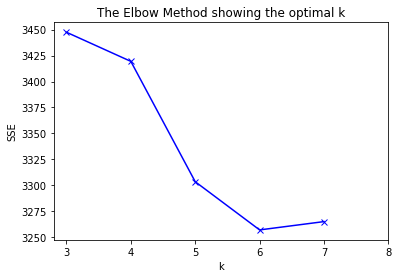

In [8]:
#To plot the graph for the elbow method.
plt.figure("K-SSE graph")
plt.plot(K, SSE, 'bx-')
plt.xticks(range(k-experiments, k+1, 1))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()